# get reasonable clusters res

In [ ]:
import tqdm
import sklearn

In [ ]:
for res in tqdm.tqdm(np.linspace(0.05, 1.5, 30)):
    res = round(res, 2)
    sc.tl.leiden(ad, resolution=res, key_added=f"leiden_{res}")

100%|██████████| 30/30 [35:47<00:00, 71.59s/it]


In [ ]:
ad_forSi = sc.pp.subsample(ad, n_obs=10000, copy=True)

In [ ]:
ar_distance = sklearn.metrics.pairwise_distances(ad_forSi.obsm["X_pca_harmony_sx"])

In [ ]:
ls_res = [round(res, 2) for res in np.linspace(0.05, 1.5, 30)]

In [ ]:
dt_silhouScore = {}
for res in tqdm.tqdm(ls_res):
    dt_silhouScore[res] = sklearn.metrics.silhouette_score(
        ar_distance, ad_forSi.obs[f"leiden_{res}"], metric="precomputed"
    )
del ar_distance

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:15<00:00,  1.94it/s]


In [ ]:
ad.uns["leiden_silhouScore"] = pd.Series(dt_silhouScore).rename("ss").to_frame()

In [ ]:
dt_silhouScore = ad.uns["leiden_silhouScore"]["ss"].to_dict()

In [ ]:
sc.tl.leiden(ad, resolution=0.4)

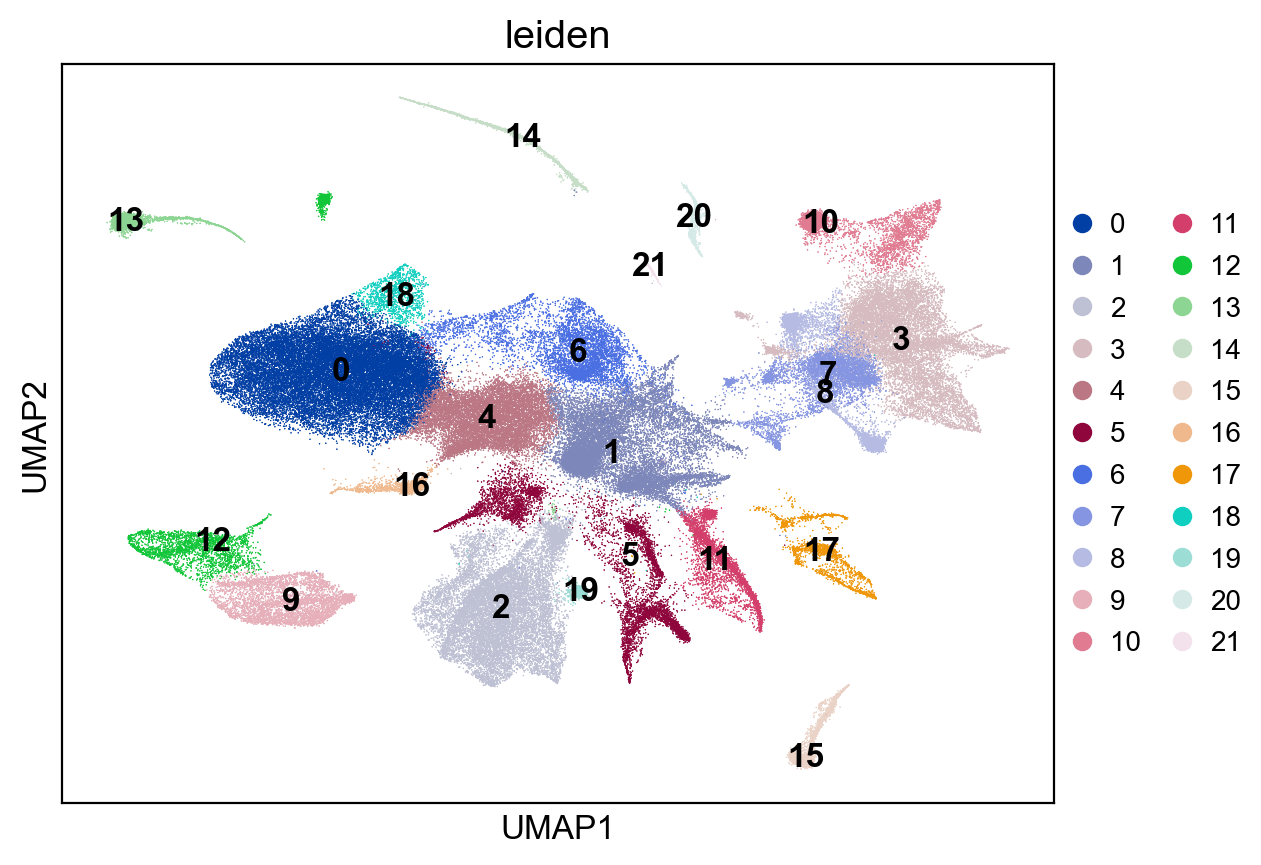

In [ ]:
ax = sc.pl.umap(ad, color="leiden", legend_loc="on data", show=False)
sc.pl.umap(
    ad,
    color="leiden",
    ax=ax,
)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
singleCellTools.plotting.plotLabelPercentageInCluster(ad, "leiden", "CT", ax=ax)

In [ ]:
ad.obs["Cluster"] = ad.obs["leiden"]

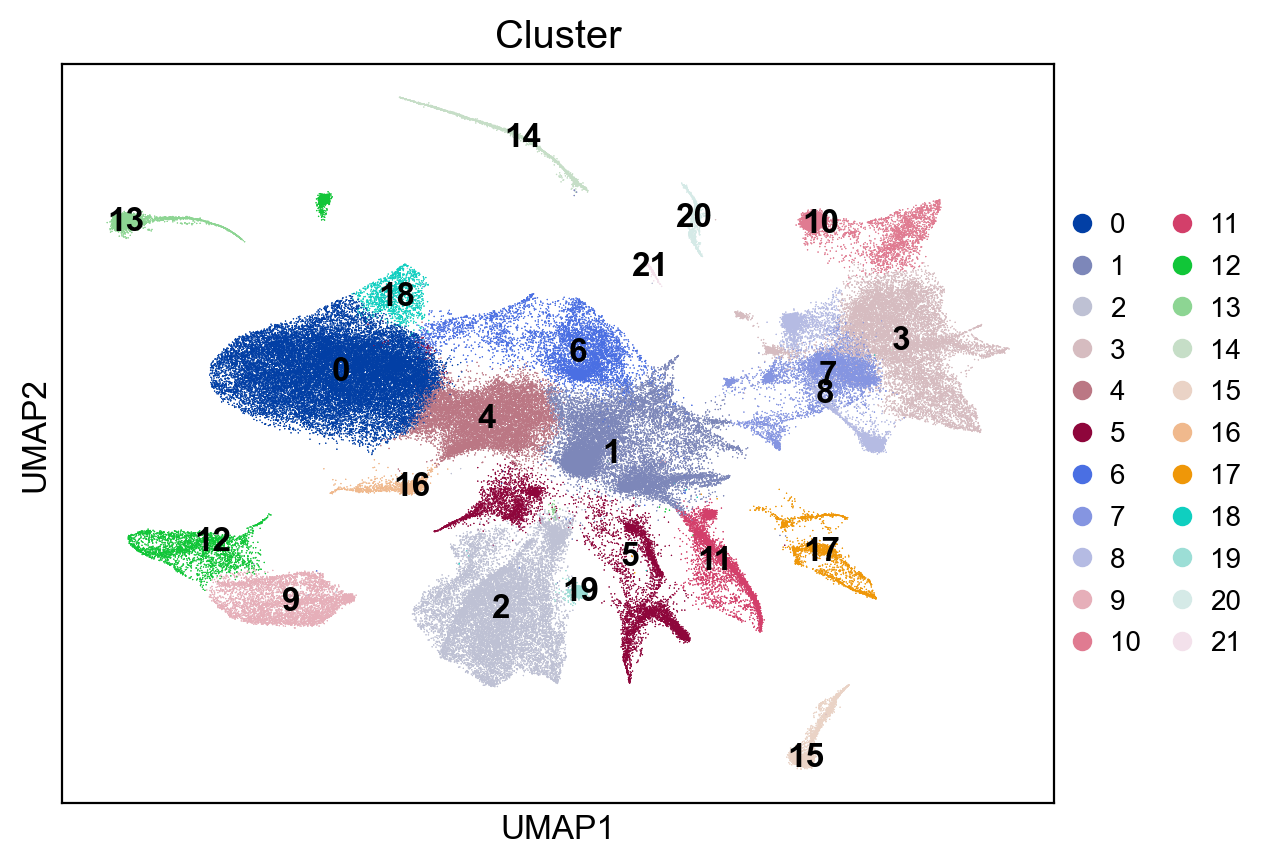

In [ ]:
ax = sc.pl.umap(ad, color="Cluster", show=False, legend_loc="on data")
sc.pl.umap(ad, color="Cluster", ax=ax)

# get spec gene of each cluster

In [ ]:
singleCellTools.geneEnrichInfo.calculateEnrichScoreByCellex(ad, "raw", "Cluster")

In [ ]:
toPkl(ad, "ad_sct_sx_20230628", "ipf", dir_path=dir_temp)

2023-06-28 21:26:11.245 | INFO     | jpy_tools.otherTools:toPkl:476 - please run `loadPkl('ad_sct_sx_20230628', lambda **dt:sc.read_h5ad(**dt), arg_path='filename')` to get object


In [ ]:
ad = loadPkl('ad_20230506_after_sct', lambda **dt:sc.read_h5ad(**dt), arg_path='filename', dir_path=dir_temp)

In [ ]:
ls_cluster = ad.uns["Cluster_cellexES"]["Cluster"].unique().tolist() >> F(
    sorted, key=lambda x: int(x.split("-")[0])
)

In [ ]:
ad.uns["Cluster_cellexES"]["Cluster"] = (
    ad.uns["Cluster_cellexES"]["Cluster"]
    .astype("category")
    .cat.set_categories(ls_cluster)
)

In [ ]:
def _cutSpecGenes(df, cutoff):
    df = df.query("enrichScore > @cutoff")
    return df.value_counts("Cluster", sort=False).rename(cutoff)


pd.concat(
    [
        _cutSpecGenes(ad.uns["Cluster_cellexES"], x)
        for x in (0.8, 0.85, 0.9, 0.95, 0.98, 0.99)
    ],
    axis=1,
)

,0.80,0.85,0.90,0.95,0.98,0.99
Cluster,,,,,,
0,799,535,297,80,13,2
1,465,341,211,75,10,1
2,613,429,278,110,19,2
3,817,545,273,79,10,0
4,456,312,174,70,29,12
5,320,243,149,67,14,2
6,353,284,206,112,43,13
7,595,402,235,98,13,1
8,35,21,14,3,0,0


In [ ]:
dt_specGenes = (
    ad.uns["Cluster_cellexES"]
    .query("enrichScore > 0.9")
    .sort_values(["Cluster", "enrichScore"], ascending=[True, False])
    .groupby("Cluster")["gene"]
    .agg(list)
    .to_dict()
)

In [ ]:
_df = ad.uns["Cluster_cellexES"].query("enrichScore > 0.9").sort_values(["Cluster", "enrichScore"], ascending=[True, False])

In [ ]:
_df.to_csv(f"{dir_result}/20230825_spec_genes.csv")

In [ ]:
f"{dir_result}/20230825_spec_genes.csv"

'/data/Zhaijx/liuzj/projects/circadian/03_analysis//20230825_spec_genes.csv'

In [ ]:
{x:len(y) for x,y in dt_specGenes.items()}

{'0': 297,
 '1': 211,
 '2': 278,
 '3': 273,
 '4': 174,
 '5': 149,
 '6': 206,
 '7': 235,
 '8': 14,
 '9': 268,
 '10': 152,
 '11': 199,
 '12': 160,
 '13': 88,
 '14': 193,
 '15': 94,
 '16': 15,
 '17': 196,
 '18': 189,
 '19': 25,
 '20': 218,
 '21': 118}

In [ ]:
dt_geneSetCounts = {x:len(y) for x,y in dt_specGenes.items()}
ls_cluster = dt_specGenes.keys()
ls_genes = sum([dt_specGenes[x] for x in ls_cluster], [])
ls_geneCategory = [[x] * dt_geneSetCounts[x] for x in ls_cluster] >> F(lambda _: sum(_, []))
# _ad = sc.pp.subsample(ad, n_obs=10000, copy=True)
_ad = ad

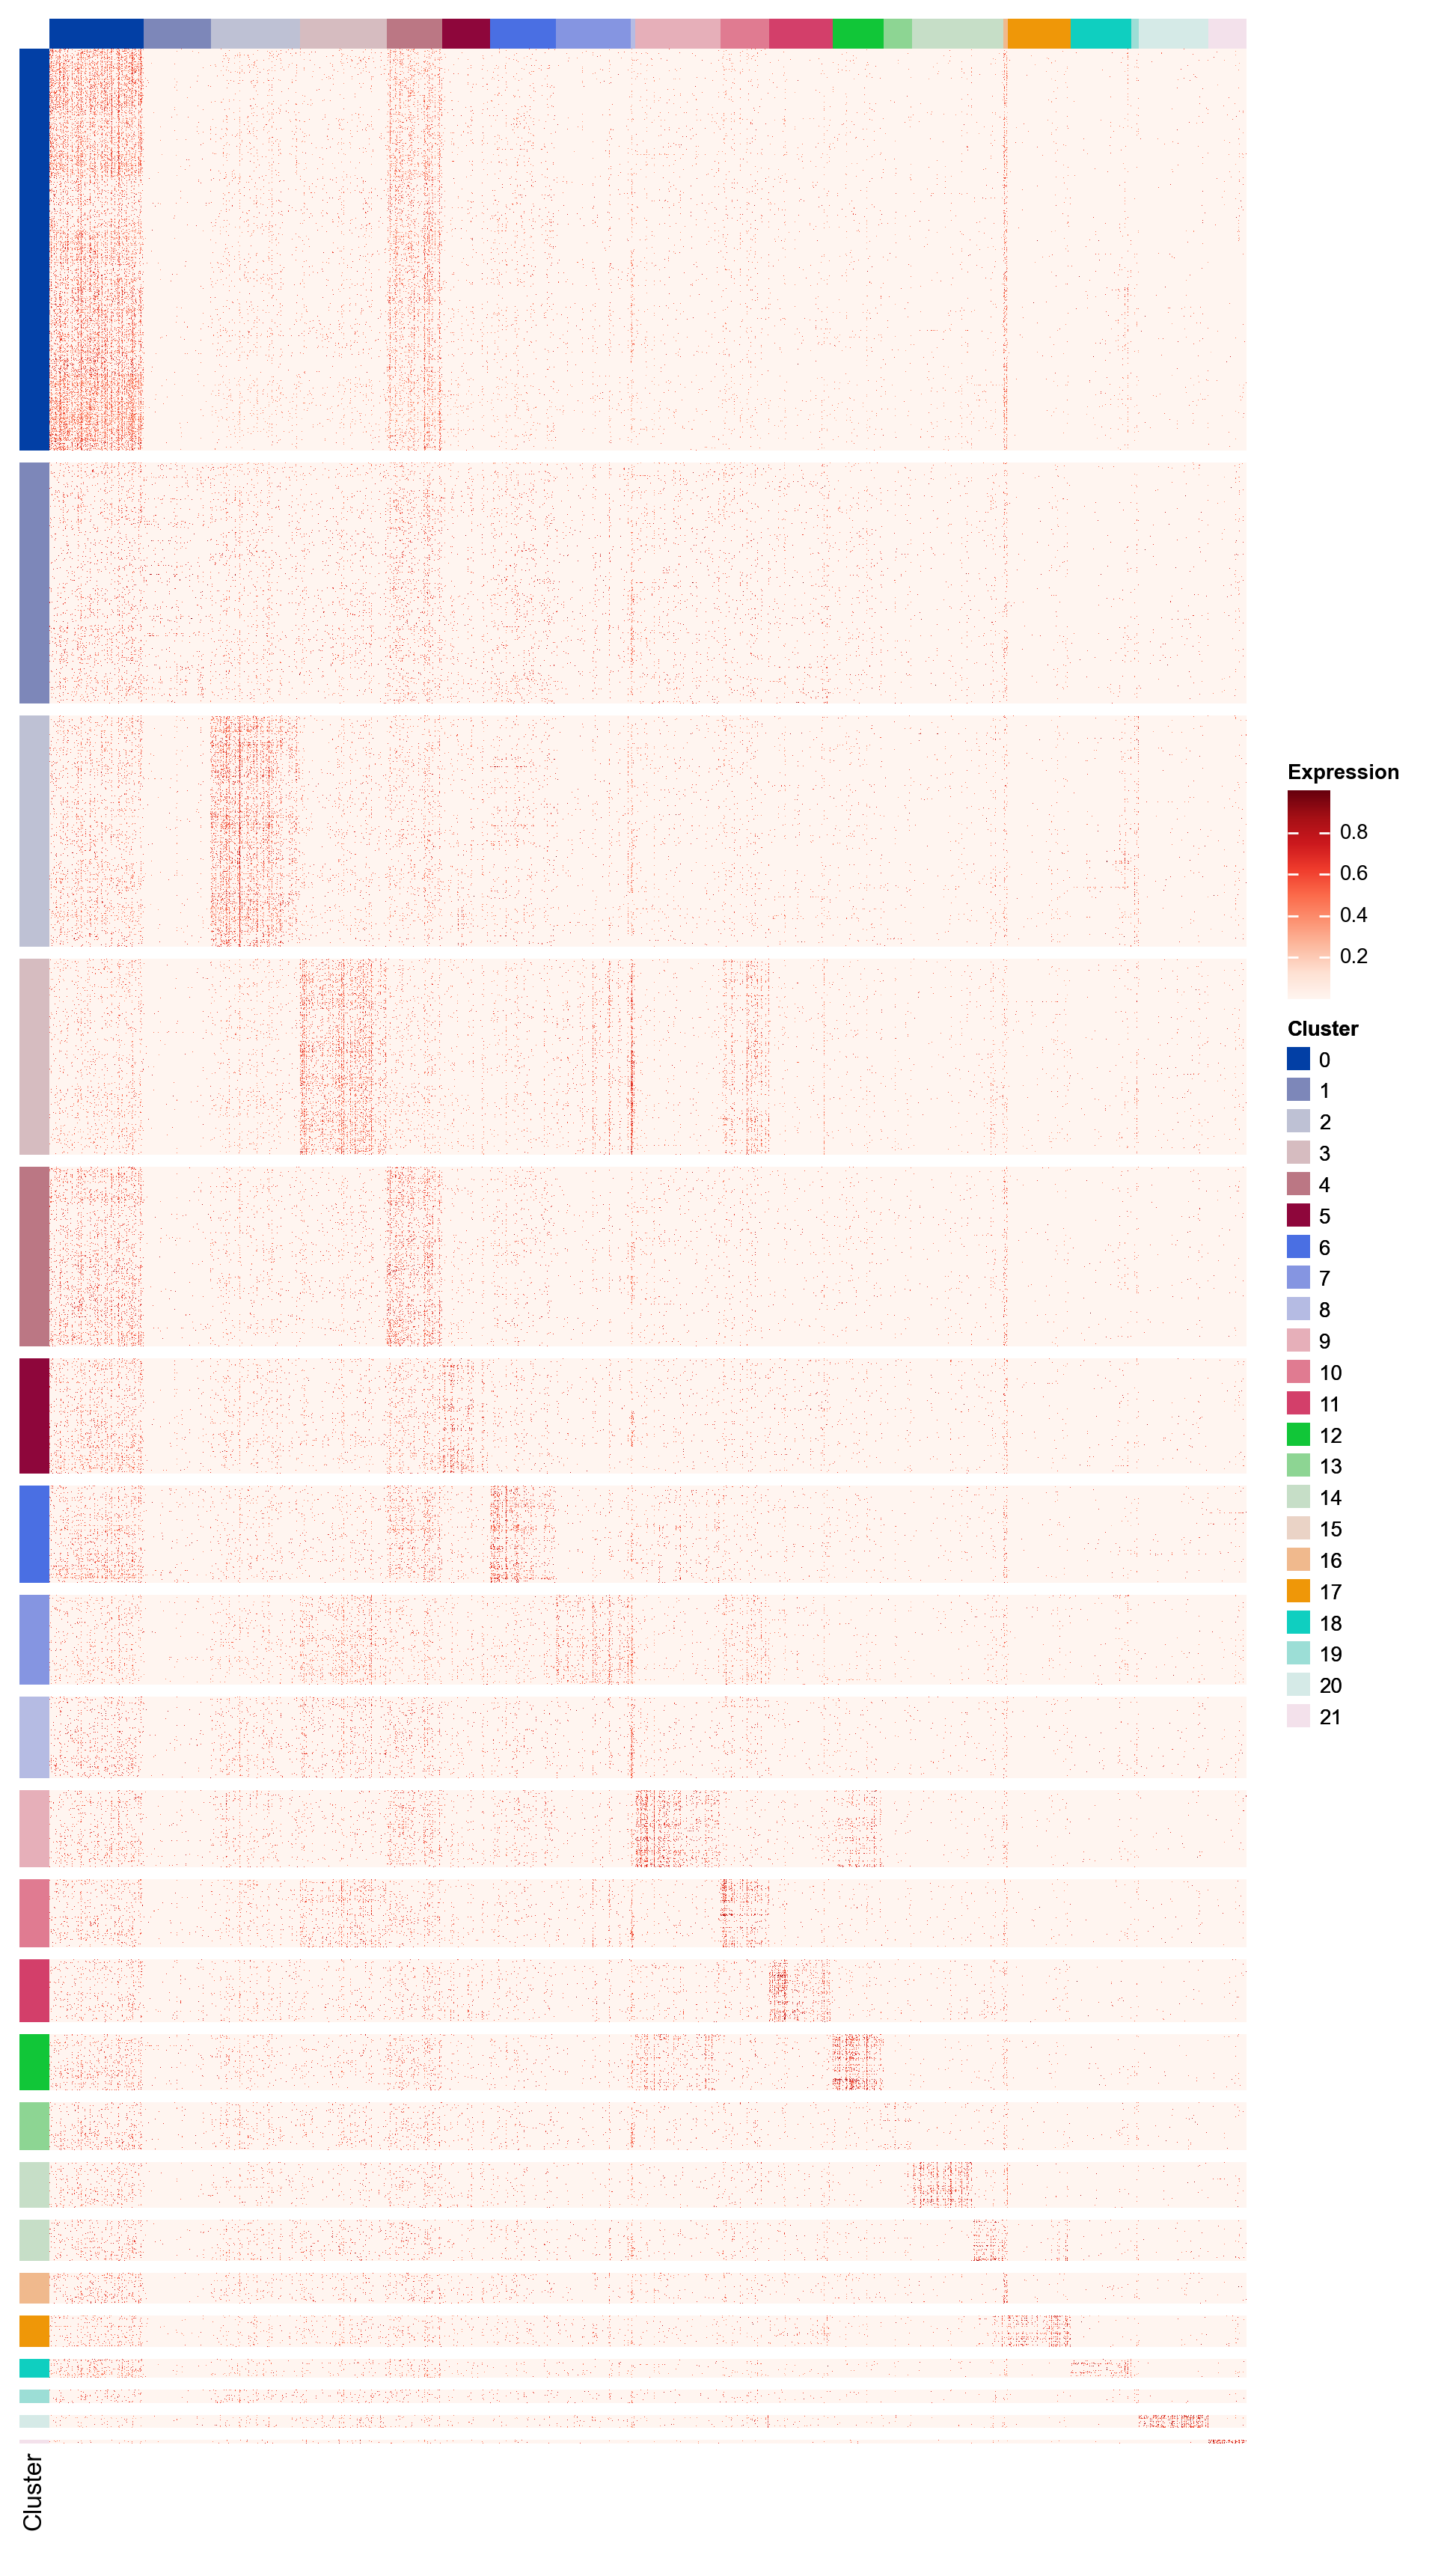

In [ ]:

df_mtx = _ad[:, ls_genes].to_df('normalize_log')
df_mtx = df_mtx.pipe(lambda _: (_ - _.min(0)) / (_.max(0) - _.min(0))).fillna(0)
m = ma.Heatmap(df_mtx.values, cmap='Reds', width=8, height=16, label='Expression')
m.hsplit(labels=_ad.obs['Cluster'], order=_ad.obs['Cluster'].cat.categories, spacing=0.005)
m.add_left(mp.Colors(data=_ad.obs['Cluster'], palette=singleCellTools.basic.getadataColor(_ad, 'Cluster'), label='Cluster'), size=0.2)
m.add_top(mp.Colors(data=ls_geneCategory, palette=singleCellTools.basic.getadataColor(_ad, 'Cluster')), size=0.2, legend=False)
m.add_legends()
m.render()